<div align="right"><i>Peter Norvig, 23 Oct, 2017</i></div>

# Bike Speed versus Grade

Like most people, I bike slower when I'm going up a steep hill than on a flat road. But how much slower?
To answer that, I downloaded all my recorded past rides 
on [Strava](https://www.strava.com/athletes/575579) that are longer than 20 miles, out them into a text file `"bikerides20.txt"`, and wrote code to parse the file:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

line = 'Ride	Thu, 8/9/2018	BRNW	4:58:07	68.41 mi	3,862 ft	' # Sample line

Ride = namedtuple('Ride', 'date, title, hours, miles, feet')

def parse_ride(line) -> Ride:
    "Turn a line (such as `sample`) in a Strava datafile into a `Ride`."
    _, date, title, time, mi, ft = line.strip().split('\t')
    times = map(int, time.split(':')[::-1])
    miles = float(mi.split()[0])
    feet  = int(ft.split()[0].replace(',', ''))
    return Ride(date, title, hours(*times), miles, feet)

def hours(sec, min, hour=0): return hour + min / 60 + sec / 3600

all_rides = {parse_ride(line) for line in open('bikerides20.txt')}

For some of the rides, the GPS was not recording elevation, so the feet field is 0. Let's eliminate those, and let's collect two vectors of numbers: one for miles per hour, and one for feet climbed per hour, and plot them:

Kept 583 out of 609 rides


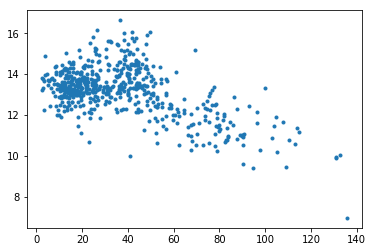

In [2]:
rides = [r for r in all_rides if r.feet > 0]
mph   = [r.miles / r.hours for r in rides]
fpm   = [r.feet / r.miles for r in rides]

plt.plot(fpm, mph, '.')
print('Kept', len(rides), 'out of', len(all_rides), 'rides')

As expected, there is a lot of variance, but overall speeds get slower as the grade gets steeper. Just eyeballing it, it looks like a curve would be a better fit than a straight line, so I'll fit a cubic (degree two) polynomial to the data, and make the plot prettier:

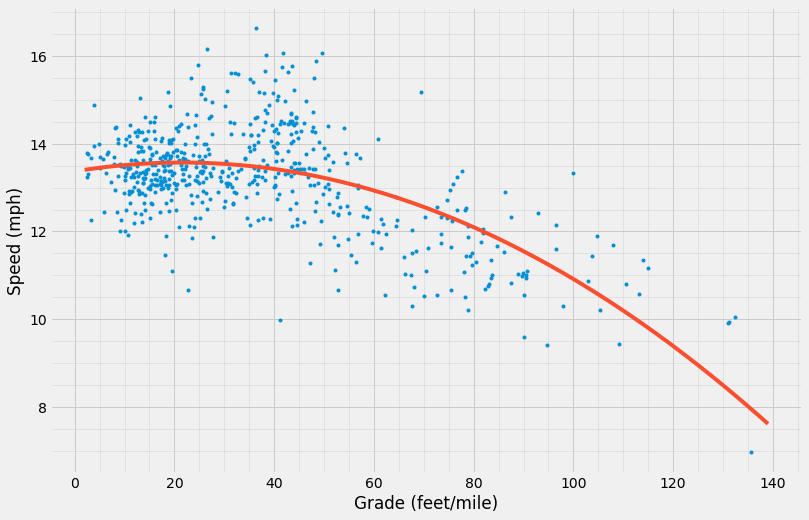

In [3]:
def poly(X, Y, n):
    "Best-fit degree-n polynomial for X, Y data."
    C = np.polyfit(X, Y, n)[::-1] # Array of coefficients, reversed
    return lambda x: sum(C[i] * x ** i for i in range(n + 1))  

def show(X, Y, xlabel='Grade (feet/mile)', ylabel='Speed (mph)', fit=True): 
    F = poly(X, Y, 2)
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.style.use('fivethirtyeight')
    plt.plot(X, Y, '.')
    X1 = list(range(int(min(X)), int(max(X)) + 5))
    if fit: plt.plot(X1, [F(x) for x in X1], '-')
    plt.ylabel(ylabel); plt.xlabel(xlabel)
    plt.minorticks_on()
    plt.grid(True, which='major')
    plt.grid(True, which='minor', alpha=0.4)
    
show(fpm, mph)     

So, I average a little under 14 mph when the overall route is fairly flat, with a lot of variability from 12 to 16 mph, depending more on my level of effort than on the grade of the road. But from 40 ft/mile and up, speed falls off quickly, and by 140 ft/mile, I'm down under 8 mph. Note that 140 ft/mile is only 2.7% grade, but if you figure a typical route is 1/3 up, 1/3 down, and 1/3 flatish, then that's 8% grade on the up part (which is at least 7 miles).

I can use the `poly` function to estimate the duration of a route:

In [4]:
def duration(dist, climb, F=poly(fpm, mph, 2)):
    "Given a distance in miles and total climb in feet, return estimated time in minutes."
    return dist / F(climb / dist) * 60

For example, to get to  Pescadero from La Honda, I could take the flatter [coast route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.4039496!2d37.3116594!3s0x808f062b7d7585e7:0x942480c22f110b74!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1), or the shorter [creek route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.3658887!2d37.2538867!3s0x808f00acf265bd43:0xb7e2a0c9ee355c3a!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1); which is faster?

In [5]:
duration(15.7, 344), duration(13.5, 735)

(69.426193865785734, 61.816569346397067)

This suggests the coast route takes 7 or 8 minutes longer. Good to know, but other factors (like the scenery) are probably more important in making the choice.

# Eddington Number

> *Your [Eddington Number](https://www.triathlete.com/2011/04/training/measuring-bike-miles-eddington-number_301789) is the largest integer **m** for which you have bicycled **m** or more miles on **m** different days.*

Let's calculate mine, and see how many rides I need to take to improve it. I'm pretty sure I've done at least 50 rides of 50 miles, so:

In [6]:
{m: m - sum(r.miles > m for r in rides)
 for m in range(50, 71)}

{50: -17,
 51: -5,
 52: 0,
 53: 3,
 54: 7,
 55: 10,
 56: 12,
 57: 16,
 58: 20,
 59: 26,
 60: 28,
 61: 34,
 62: 37,
 63: 40,
 64: 43,
 65: 45,
 66: 47,
 67: 51,
 68: 52,
 69: 56,
 70: 57}

The entry `{52: 0}` means **my Eddington Number is 52**: I've done 52 rides of 52 miles or more (at least of the ones that were recorded by Strava). I'd need only 3 rides of 53 miles to add one to my number, but I'd need a whopping 57 rides of 70 miles or more to get my number up to 70. Let's look at my distribution of ride distances, for my 40+ mile rides:

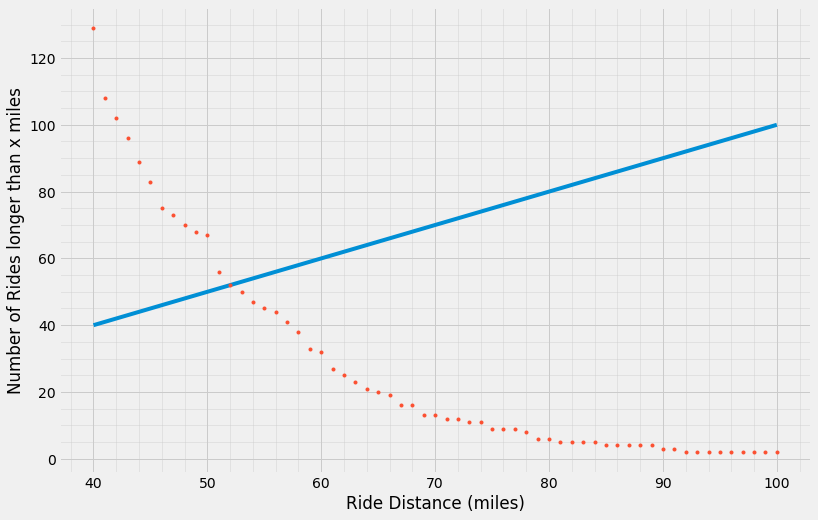

In [7]:
X = range(40, 101)
M = [min(X), max(X)]
plt.plot(M, M, '-')
show(X, [sum(r.miles > x for r in rides) for x in X], fit=False,
     xlabel='Ride Distance (miles)', ylabel='Number of Rides longer than x miles')

Here the gap between the straight line and the dotted line is my Eddington gap: the lines cross at 52 so that's my Eddington Number; at 60 miles the gap is 28.

## Metric Eddington Number

[Arthur Eddington](https://en.wikipedia.org/wiki/Arthur_Eddington) was born in 19th century England, so he used miles. You can get a more impressive number with your **metric** Eddington Number:

In [8]:
def kms(ride): return ride.miles * 1.60934

{m: m - sum(kms(r) > m for r in rides)
 for m in range(70, 91)}

{70: -22,
 71: -17,
 72: -12,
 73: -5,
 74: -1,
 75: 2,
 76: 4,
 77: 6,
 78: 9,
 79: 11,
 80: 13,
 81: 17,
 82: 26,
 83: 28,
 84: 33,
 85: 35,
 86: 37,
 87: 40,
 88: 42,
 89: 44,
 90: 46}

My metric Eddington Number is 74, and I only need 13 rides of 80 km (50 miles) to get to 80.

# H-Index

Inspired by the [h-index](https://en.wikipedia.org/wiki/H-index) for scientific publications (and indirectly by Eddington), I invented a new h-index, or hill-index:

> *Your **h-index** is the largest integer **h** for which you can persistently and repeatedly climb an **h** percent grade at **h** miles per hour.*

My h-index is 6, because I regularly climb a 6% grade at 6 miles per hour or more, but I only occasionally climb a 7% grade at 7 mph. What's yours?